In [3]:

import tensorflow as tf
print(tf.__version__)
import pandas as pd
import gc
import numpy as np
import matplotlib.pyplot as plt
import gc
import tensorflow as tf
from sklearn.model_selection import TimeSeriesSplit


2.14.0


In [2]:

physical_devices = tf.config.list_physical_devices('GPU')
print(physical_devices)


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [4]:

df = pd.read_csv("/Users/chidam_sp/daily_min_temperatures_week4_sequential_time_series_coursera.csv")



In [5]:

import csv
time_step = []
temps = []

with open("/Users/chidam_sp/daily_min_temperatures_week4_sequential_time_series_coursera.csv") as csvfile:
  reader = csv.reader(csvfile, delimiter=',')
  next(reader)
  step = 0
  for row in reader:
    temps.append(float(row[1]))
    time_step.append(step)
    step = step + 1

series = np.array(temps)
time = np.array(time_step)



In [6]:

len(df)


3650

In [7]:

split_time = 3000

# Get the train set 
time_train = time[:split_time]# YOUR CODE HERE
x_train = series[:split_time]# YOUR CODE HERE

# Get the validation set
time_valid = time[split_time:]# YOUR CODE HERE
x_valid = series[split_time:]# YOUR CODE HERE


In [22]:
del df, time_train, time_valid, x_train, x_valid
gc.collect()

11638

In [8]:

def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    
    # Generate a TF Dataset from the series values
    dataset = tf.data.Dataset.from_tensor_slices(series)

    
    # Window the data but only take those with the specified size
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    
    # Flatten the windows by putting its elements in a single batch
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1)) ##the None dimension invoked by window.batch is 
    ##of course necessary 

    # Create tuples with features and labels 
    dataset = dataset.map(lambda window: (window[:-1], window[-1]))


    # Shuffle the windows
    dataset = dataset.shuffle(shuffle_buffer)
    
    # Create batches of windows
    dataset = dataset.batch(batch_size).prefetch(1)
    
    return dataset



In [9]:

tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

window_size = 64
batch_size = 256
shuffle_buffer_size = 1000

train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
print(train_set)


<_PrefetchDataset element_spec=(TensorSpec(shape=(None, None, 1), dtype=tf.float64, name=None), TensorSpec(shape=(None, 1), dtype=tf.float64, name=None))>


2024-02-09 18:19:52.974851: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2 Pro
2024-02-09 18:19:52.974878: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2024-02-09 18:19:52.974896: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2024-02-09 18:19:52.974938: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-02-09 18:19:52.974957: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [10]:

tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
window_size = 64
batch_size = 256
train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
print(train_set)
print(x_train.shape)

model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=32, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(learning_rate=1e-8, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])


<_PrefetchDataset element_spec=(TensorSpec(shape=(None, None, 1), dtype=tf.float64, name=None), TensorSpec(shape=(None, 1), dtype=tf.float64, name=None))>
(3000,)


Epoch 1/100


2024-02-09 18:22:32.265493: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.
2024-02-09 18:22:32.326695: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node SGD/AssignVariableOp.


12/12 [==============================] - 5s 65ms/step - loss: 157.8308 - mae: 158.3302 - lr: 1.0000e-08
Epoch 2/100
 4/12 [=========>....................] - ETA: 0s - loss: 154.8618 - mae: 155.3612

2024-02-09 18:22:36.051546: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 7029575970301495797
2024-02-09 18:22:36.051567: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 1437452272640402650
2024-02-09 18:22:36.051570: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 768491095830372208


12/12 [==============================] - 0s 19ms/step - loss: 154.3390 - mae: 154.8385 - lr: 1.1220e-08
Epoch 3/100
12/12 [==============================] - 0s 19ms/step - loss: 149.2837 - mae: 149.7831 - lr: 1.2589e-08
Epoch 4/100
12/12 [==============================] - 0s 19ms/step - loss: 143.3858 - mae: 143.8853 - lr: 1.4125e-08
Epoch 5/100
12/12 [==============================] - 0s 20ms/step - loss: 136.7848 - mae: 137.2842 - lr: 1.5849e-08
Epoch 6/100
12/12 [==============================] - 0s 21ms/step - loss: 129.4162 - mae: 129.9156 - lr: 1.7783e-08
Epoch 7/100
12/12 [==============================] - 0s 19ms/step - loss: 121.1547 - mae: 121.6540 - lr: 1.9953e-08
Epoch 8/100
12/12 [==============================] - 0s 20ms/step - loss: 111.6719 - mae: 112.1711 - lr: 2.2387e-08
Epoch 9/100
12/12 [==============================] - 0s 23ms/step - loss: 100.4093 - mae: 100.9084 - lr: 2.5119e-08
Epoch 10/100
12/12 [==============================] - 0s 20ms/step - loss: 86.0418 -

In [28]:

history.history


{'loss': [3.2813432216644287,
  2.6219046115875244,
  2.5802228450775146,
  2.360492706298828,
  2.3499042987823486,
  2.3195276260375977,
  2.379138231277466,
  2.3538782596588135,
  2.264666795730591,
  2.2809269428253174,
  2.294295310974121,
  2.474809408187866,
  2.300877809524536,
  2.312159299850464,
  2.2635302543640137,
  2.2767012119293213,
  2.224452495574951,
  2.422675371170044,
  2.2617154121398926,
  2.3477566242218018,
  2.379575729370117,
  2.3360416889190674,
  2.2787563800811768,
  2.2112607955932617,
  2.3227524757385254,
  2.254638433456421,
  2.2346274852752686,
  2.345258951187134,
  2.2533130645751953,
  2.278928756713867,
  2.300014019012451,
  2.2431342601776123,
  2.2471683025360107,
  2.3344991207122803,
  2.223003387451172,
  2.2054805755615234,
  2.2934205532073975,
  2.5824666023254395,
  2.3599233627319336,
  2.2652480602264404,
  2.302238941192627,
  2.275879144668579,
  2.2694005966186523,
  2.2997753620147705,
  2.2122974395751953,
  2.193385124206543

(1e-08, 0.0001, 0.0, 60.0)

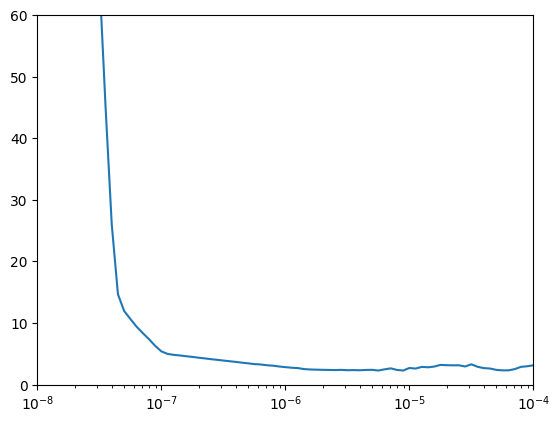

In [11]:

plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-4, 0, 60])


In [24]:
min(history.history["lr"]), max(history.history["lr"])

KeyError: 'lr'

In [12]:

tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
train_set = windowed_dataset(x_train, window_size=60, batch_size=100, shuffle_buffer=shuffle_buffer_size)
model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=60, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])


optimizer = tf.keras.optimizers.SGD(learning_rate=5e-6, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set,epochs=200)


Epoch 1/200


2024-02-09 18:23:40.675040: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node SGD/AssignVariableOp.


30/30 [==============================] - 3s 38ms/step - loss: 3.2813 - mae: 3.7501
Epoch 2/200
 4/30 [===>..........................] - ETA: 0s - loss: 2.9473 - mae: 3.4166

2024-02-09 18:23:42.693796: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 7029575970301495797


30/30 [==============================] - 1s 21ms/step - loss: 2.6219 - mae: 3.0871
Epoch 3/200
30/30 [==============================] - 1s 19ms/step - loss: 2.5802 - mae: 3.0438
Epoch 4/200
30/30 [==============================] - 1s 24ms/step - loss: 2.3605 - mae: 2.8210
Epoch 5/200
30/30 [==============================] - 1s 20ms/step - loss: 2.3499 - mae: 2.8109
Epoch 6/200
30/30 [==============================] - 1s 21ms/step - loss: 2.3195 - mae: 2.7808
Epoch 7/200
30/30 [==============================] - 1s 20ms/step - loss: 2.3791 - mae: 2.8404
Epoch 8/200
30/30 [==============================] - 1s 20ms/step - loss: 2.3539 - mae: 2.8146
Epoch 9/200
30/30 [==============================] - 1s 20ms/step - loss: 2.2647 - mae: 2.7243
Epoch 10/200
30/30 [==============================] - 1s 19ms/step - loss: 2.2809 - mae: 2.7403
Epoch 11/200
30/30 [==============================] - 1s 19ms/step - loss: 2.2943 - mae: 2.7536
Epoch 12/200
30/30 [==============================] - 1s 18m

In [14]:

def plot_series_1(x, y, format="-", start=0, end=None, 
                title=None, xlabel=None, ylabel=None, legend=None ):
    """
    Visualizes time series data

    Args:
      x (array of int) - contains values for the x-axis
      y (array of int or tuple of arrays) - contains the values for the y-axis
      format (string) - line style when plotting the graph
      start (int) - first time step to plot
      end (int) - last time step to plot
      title (string) - title of the plot
      xlabel (string) - label for the x-axis
      ylabel (string) - label for the y-axis
      legend (list of strings) - legend for the plot
    """

    # Setup dimensions of the graph figure
    plt.figure(figsize=(10, 6))
    
    # Check if there are more than two series to plot
    if type(y) is tuple:

      # Loop over the y elements
      for y_curr in y:

        # Plot the x and current y values
        plt.plot(x[start:end], y_curr[start:end], format)

    else:
      # Plot the x and y values
      plt.plot(x[start:end], y[start:end], format)

    # Label the x-axis
    plt.xlabel(xlabel)

    # Label the y-axis
    plt.ylabel(ylabel)

    # Set the legend
    if legend:
      plt.legend(legend)

    # Set the title
    plt.title(title)

    # Overlay a grid on the graph
    plt.grid(True)

    # Draw the graph on screen
    plt.show()


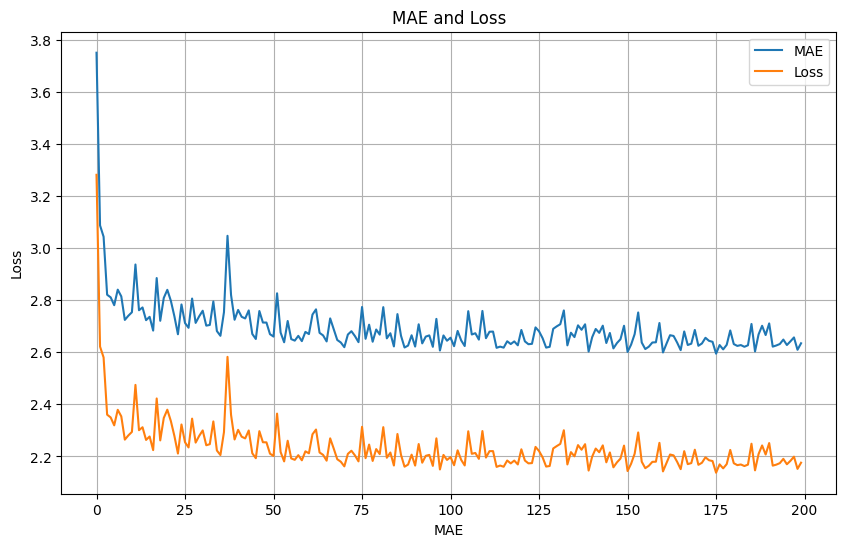

In [15]:

# Get mae and loss from history log
mae=history.history['mae']
loss=history.history['loss']

# Get number of epochs
epochs=range(len(loss)) 

# Plot mae and loss
plot_series_1(x=epochs, y=(mae, loss), title='MAE and Loss', xlabel='MAE', ylabel='Loss', legend=['MAE', 'Loss'])



In [23]:

min(loss), max(loss)


(2.1376194953918457, 3.2813432216644287)

In [ ]:

min(loss), max(loss)


In [16]:

def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast


In [17]:

forecast = model_forecast(model, series[..., np.newaxis], window_size)
forecast = forecast[split_time - window_size:-1, -1, 0]


113/113 [==============================] - 2s 10ms/step


2024-02-09 18:26:59.069234: I tensorflow/core/framework/local_rendezvous.cc:425] Local rendezvous send item cancelled. Key hash: 11714292402085696434
2024-02-09 18:26:59.069249: I tensorflow/core/framework/local_rendezvous.cc:425] Local rendezvous send item cancelled. Key hash: 13155882844870248777
2024-02-09 18:26:59.069256: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 6528657074748034964


<Figure size 1000x600 with 0 Axes>

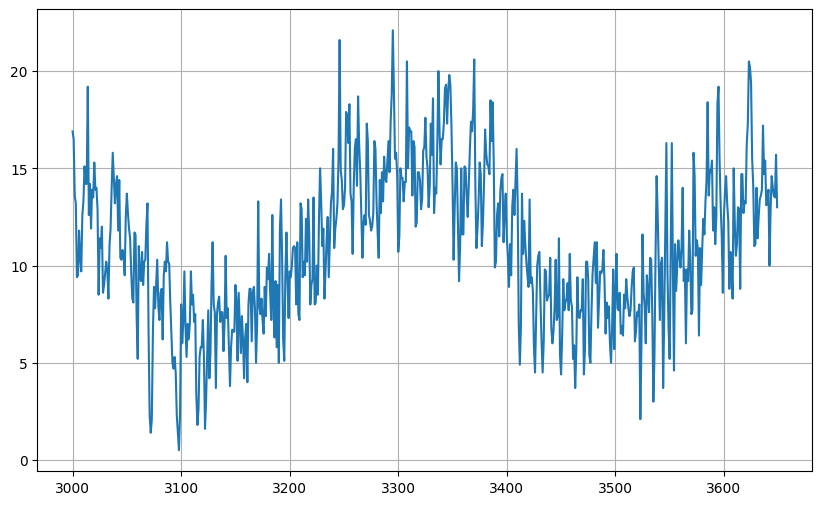

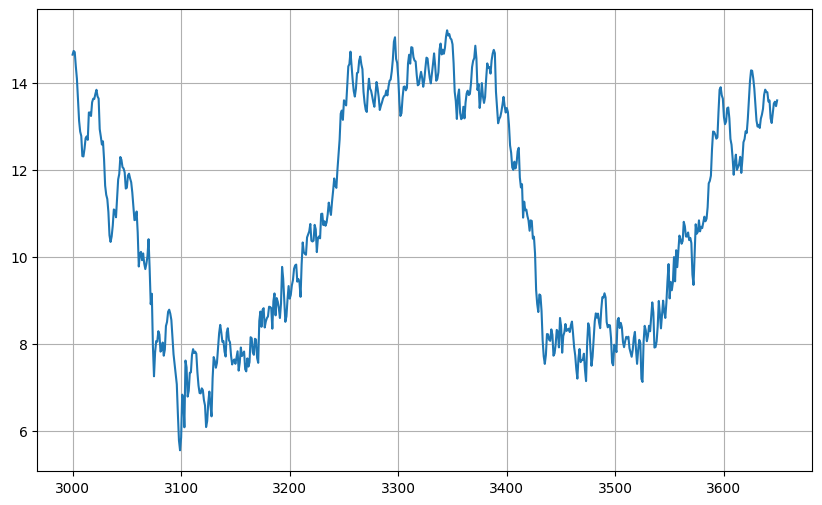

In [19]:

plt.figure(figsize=(10, 6))
plot_series_1(time_valid, x_valid)
plot_series_1(time_valid, forecast)


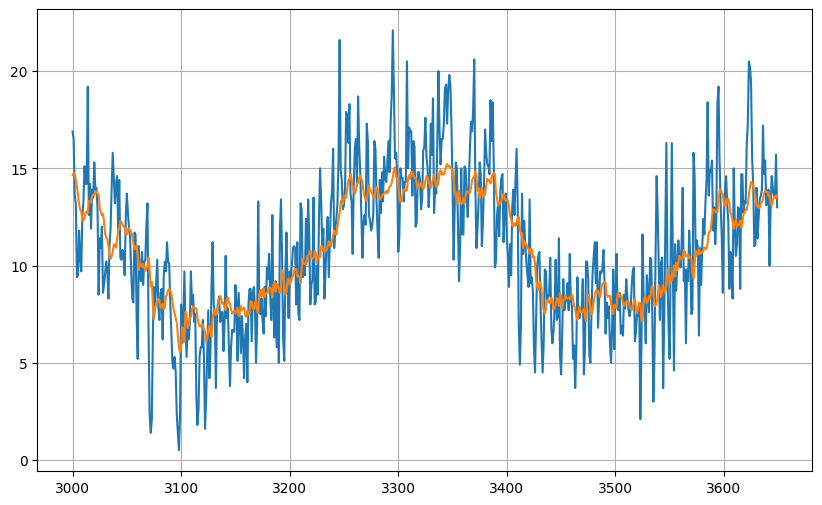

In [20]:


plot_series_1(time_valid, (x_valid, forecast))


In [21]:

tf.keras.metrics.mean_absolute_error(x_valid, forecast).numpy()


1.9140223

In [29]:

del model, forecast, history
gc.collect()


968